## Regressione con Random Forest

Uso i dati divisi per comune e per giorno dei 2 giorni precedenti per prevedere le zone con consumo elettrico alto nel giorno successivo

In [33]:
import pandas as pd
import geopandas as gpd

import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.metrics import matthews_corrcoef, confusion_matrix, roc_curve, precision_recall_curve

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10, 10]


## Importo i dati

In [34]:
data = pd.read_csv('data/processed/classificazione.csv')
columns = data.columns

In [35]:
target = data['highPower']

In [36]:
features_names = columns[1:len(columns)-1]
features = data[features_names]

In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2, random_state=1)

In [38]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Random Forest classifier

In [40]:
rfc = RandomForestClassifier(n_estimators=100) #da modificare a 100
rfc.fit(X_train, Y_train)

print(f"Score on train = {rfc.score(X_train, Y_train)}")
print(f"Score on test = {rfc.score(X_test, Y_test)}")

Score on train = 1.0
Score on test = 0.9894736842105263


<BarContainer object of 33 artists>

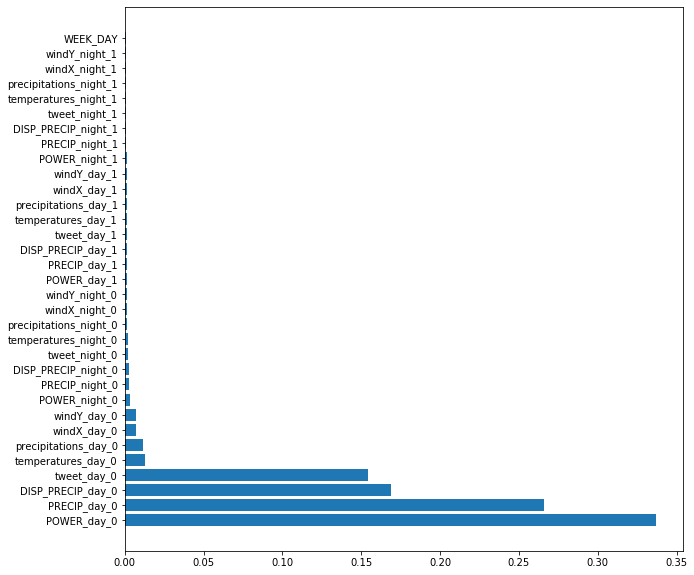

In [41]:
res = pd.DataFrame(data = rfc.feature_importances_, index = features_names, columns=['weight'],dtype=float)
res.sort_values(by=['weight'], ascending = False, inplace = True)

plt.barh(y = features_names, width = res["weight"].tolist())

In [15]:
res

weight
POWER_night_0           0.287121
POWER_night_1           0.251761
POWER_day_1             0.200386
POWER_day_0             0.175382
tweet_night_1           0.014385
tweet_night_0           0.013216
tweet_day_0             0.012119
tweet_day_1             0.009127
PRECIP_day_1            0.003101
PRECIP_day_0            0.002682
PRECIP_night_0          0.002101
WEEK_DAY                0.002063
PRECIP_night_1          0.002056
temperatures_day_0      0.002047
temperatures_night_0    0.002015
windY_day_1             0.001628
windX_night_0           0.001624
windX_day_0             0.001617
temperatures_day_1      0.001598
windY_day_0             0.001496
windY_night_0           0.001447
windX_night_1           0.001417
temperatures_night_1    0.001389
windY_night_1           0.001382
windX_day_1             0.001325
precipitations_night_0  0.001103
precipitations_day_0    0.000965
precipitations_night_1  0.000658
precipitations_day_1    0.000618
DISP_PRECIP_day_0       0.000606
DISP_PRECIP_night_0     0.000555
DISP_PRECIP_night_1     0.000515
DISP_PRECIP_day_1       0.000497

# Curva ROC e Precision-Recall

In [20]:
rfcb = RandomForestClassifier(criterion='entropy', class_weight='balanced', oob_score=True)

In [21]:
param_grid = {'n_estimators':[100,250],'max_depth':[5,25,50],'max_features':[4,6]}

In [22]:
gs_CV = GridSearchCV(cv=10, error_score=..., estimator=rfcb, param_grid=param_grid)
gs_CV.fit(X_train, Y_train)


GridSearchCV(cv=10, error_score=Ellipsis,
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=True, random_state=None,
                                              ve

In [24]:
print(f"Score on train = {gs_CV.score(X_train, Y_train)}")
print(f"Score on test = {gs_CV.score(X_test, Y_test)}")

res = pd.DataFrame(data = gs_CV.best_estimator_.feature_importances_, index = features_names, columns=['weight'],dtype=float)
res.sort_values(by=['weight'], ascending = False, inplace = True)

res

Score on train = 1.0
Score on test = 0.988663967611336


weight
POWER_night_0           0.348602
POWER_night_1           0.265348
POWER_day_1             0.158986
POWER_day_0             0.135835
tweet_day_0             0.010113
tweet_night_0           0.009042
WEEK_DAY                0.007203
tweet_day_1             0.006420
tweet_night_1           0.004842
PRECIP_day_1            0.004014
windY_night_1           0.003602
temperatures_day_0      0.003348
windX_night_0           0.003283
windX_day_0             0.003260
windY_day_1             0.003116
temperatures_night_0    0.003059
PRECIP_day_0            0.003047
windY_night_0           0.002978
windX_night_1           0.002821
temperatures_night_1    0.002691
windY_day_0             0.002568
windX_day_1             0.002523
PRECIP_night_0          0.002446
temperatures_day_1      0.002149
PRECIP_night_1          0.001791
precipitations_night_0  0.001319
precipitations_day_0    0.001033
DISP_PRECIP_day_0       0.000910
precipitations_day_1    0.000878
DISP_PRECIP_night_0     0.000804
DISP_PRECIP_day_1       0.000743
precipitations_night_1  0.000669
DISP_PRECIP_night_1     0.000557

In [30]:
gs_CV.predict_proba(X_test)[:,1]

array([1., 0., 0., ..., 1., 0., 0.])

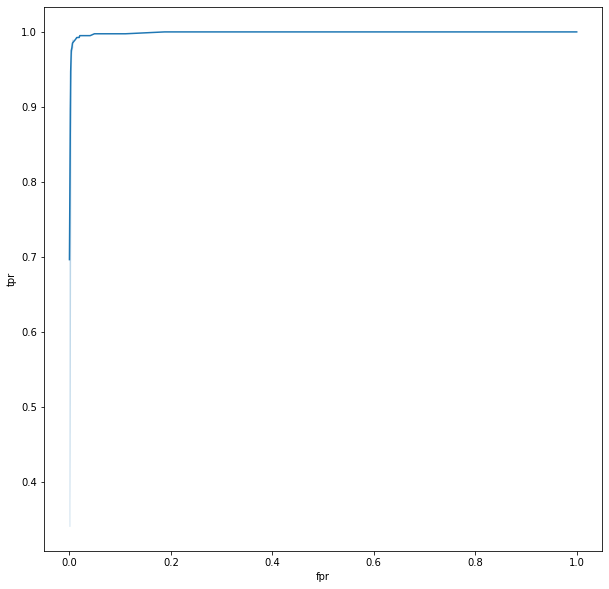

In [42]:
proba = gs_CV.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(Y_test, proba)

Data = {'fpr': fpr, 'tpr': tpr, 'threshold': threshold}
rocData = pd.DataFrame(Data)

sns.lineplot(data = rocData, x = 'fpr', y = "tpr")

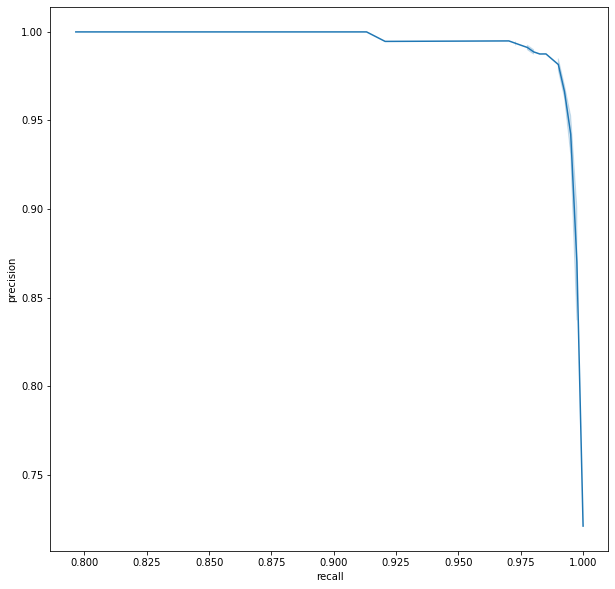

In [44]:
precision, recall, threshold = precision_recall_curve(Y_test, proba)



Data = {'precision': precision[:-1], 'recall': recall[:-1], 'threshold': threshold}
rocData = pd.DataFrame(data = Data)

sns.lineplot(data = rocData, x = 'recall', y = "precision")


## Conclusioni
Il classificatore RandomForest come è possibile vedere presenta classifica tutti i dati sul set di train correttamente, mentre per sul set di test lo score è di 0.99. Quindi si può dire che il modello utilizzato funziona bene nel prevedere il target.

Dalla curva ROC possiamo dire che il classificatore è molto buono perchè abbiamo pochi falsi positivi pur avendo pochi falsi negativi, anche dalla curva Precision-Recall possimo vedere che lo sbilanciamento delle classi non elevato, ciò conferma la bontà del modello